Homework 4
---

In this homework assignment you will be tasked with implementing a K-means clustering and a Gaussian mixture model using Gibbs sampling. You may refer to the lecture slides on clustering for the high level overview of implementing these algorithms. For the case of the Gaussian mixture model, suppose our data generating process is:

$X_i \sim N(\mu_{z_i}, \sigma^2_0 I)$

$\mu_k \sim N(\mu_0, \tau^2_0)$

$z_i \sim \mbox{Categorical}(\pi)$

$\pi \sim \mbox{Dirichlet}(\alpha_0)$

You may fix the value of the hyperpriors $\sigma_0^2,\tau^2_0, \mu_0, \alpha_0$. Note that the likelihood for $X_i$ is a multivariate Gaussian distribution.

---

1.) Derive the posterior updates for the parameters $\mu_k, \pi, z_i$. For deriving the full conditional of $\mu_k$, two properties that may be useful are the properties of the conditional distribution of a m.v. Gaussian (https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions) and completing the square of a matrix (https://en.wikipedia.org/wiki/Completing_the_square#Matrix_case).

2.) Compare the Gibbs sampling algorithm using the posterior updates you wrote in Question 1 with the K-Means algorithm. Under what conditions is the K-Means algorithm a special case of the Gibbs sampler for a GMM?

3.) Now, implement the Gibbs sampler for the GMM and the K-Means algorithm. Test to see if your implementation works correctly by fitting the model by generating some synthetic data. You may use the function `sklearn.datasets.make_blobs' with the default setting to test this. One quantitative way to measure the performance per iteration to track the progress of your model is to calculate the log-likelihood of the data per iteration. If it improves on average, then you may be in the right direction (this is not mandatory, but it should help during the debugging process).

4.) Fit the data to the `sklearn.datasets.load_digits' handwritten data set. It may be helpful to rescale the data to have zero mean and unit variance. Try to plot the cluster centers, comment on the performance.




In [7]:
# Import libraries
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits

In [8]:
# K-means
class KMeans:
    def __init__(self, k=3, max_iters=100, tol=1e-4):
        self.k = k # Number of clusters
        self.max_iters = max_iters # Max number of iterations
        self.tol = tol # Tolerance for convergence
        self.centroids = None 
        self.clusters = None

    def fit(self, X):
        # Randomly initialize centroids
        self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]
        prev_centroids = self.centroids.copy()

        for it in range(self.max_iters):
            # Assign clusters
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            self.clusters = np.argmin(distances, axis=1)
            
            # Calculate new centroids
            for i in range(self.k):
                points_in_cluster = X[self.clusters == i]
                if len(points_in_cluster) > 0:
                    self.centroids[i] = points_in_cluster.mean(axis=0)
            
            # Check for convergence
            centroid_shift = np.linalg.norm(self.centroids - prev_centroids)
            if centroid_shift < self.tol:
                break
            prev_centroids = self.centroids.copy()

    def predict(self, X):
        # Assign clusters
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)


In [9]:
# Test the KMeans class
X, _ = make_blobs() # Generate synthetic data

kmeans = KMeans(k=3)
kmeans.fit(X)
clusters = kmeans.predict(X)
print("Centroids:\n", kmeans.centroids)

Centroids:
 [[-2.25140534  2.54251795]
 [-7.78644096 -5.0945248 ]
 [ 8.57285943 -8.14260741]]


In [17]:
# Gibbs Sampler for GMM
class GMMGibbsSampler:
    def __init__(self, K, sigma2_0, tau2_0, mu_0, alpha_0, n_iter=100):
        self.K = K  # Number of clusters
        self.sigma2_0 = sigma2_0  # Data variance
        self.tau2_0 = tau2_0  # Cluster mean prior variance
        self.mu_0 = mu_0  # Cluster mean prior mean
        self.alpha_0 = alpha_0  # Dirichlet prior
        self.n_iter = n_iter  # Number of iterations for Gibbs sampling

    def initialize_parameters(self, X):
        N, D = X.shape
        self.z = np.random.choice(self.K, N)  # Cluster assignments
        self.pi = np.random.dirichlet(self.alpha_0 * np.ones(self.K))  # Mixing coefficients
        self.mu = np.random.normal(self.mu_0, np.sqrt(self.tau2_0), (self.K, D))  # Cluster means

    def sample_z(self, X):
        N, D = X.shape
        for i in range(N):
            # Calculate the full conditional probabilities of z_i
            log_probs = np.zeros(self.K)
            for k in range(self.K):
                log_probs[k] = np.log(self.pi[k]) - 0.5 * np.sum((X[i] - self.mu[k])**2) / self.sigma2_0
            # Convert log probabilities to actual probabilities
            probs = np.exp(log_probs - np.max(log_probs))
            probs /= np.sum(probs)
            # Sample the new cluster assignment for X_i
            self.z[i] = np.random.choice(self.K, p=probs)
    
    def sample_mu(self, X):
        N, D = X.shape
        for k in range(self.K):
            # Get all data points assigned to cluster k
            X_k = X[self.z == k]
            N_k = X_k.shape[0]
    
            # Calculate posterior parameters for mu_k
            posterior_mean = (self.mu_0 / self.tau2_0 + X_k.sum(axis=0) / self.sigma2_0) / (1 / self.tau2_0 + N_k / self.sigma2_0)
            posterior_var = 1 / (1 / self.tau2_0 + N_k / self.sigma2_0)
    
            # Sample the new mean for cluster k
            self.mu[k] = np.random.normal(posterior_mean, np.sqrt(posterior_var))

    def sample_pi(self):
        # Calculate the parameters for the Dirichlet posterior
        alpha_k = self.alpha_0 + np.array([np.sum(self.z == k) for k in range(self.K)])
    
        # Sample the new mixing coefficients
        self.pi = np.random.dirichlet(alpha_k)

    '''
    def log_likelihood(self, X):
        N, D = X.shape
        log_likelihood = 0
        for i in range(N):
            likelihood_i = 0
            for k in range(self.K):
                likelihood_i += self.pi[k] * multivariate_normal.pdf(X[i], mean=self.mu[k], cov=self.sigma2_0 * np.eye(D))
            log_likelihood += np.log(likelihood_i)
        return log_likelihood
    
    def fit(self, X):
        self.initialize_parameters(X)
        log_likelihoods = []  # Initialize a list to store log-likelihoods
        for iter in range(self.n_iter):
            self.sample_z(X)
            self.sample_mu(X)
            self.sample_pi()
            
            # Calculate log likelihood
            current_log_likelihood = self.log_likelihood(X)
            log_likelihoods.append(current_log_likelihood)
    
        return self.z, self.mu, self.pi, log_likelihoods
    '''
    
    def fit(self, X):
        self.initialize_parameters(X)
        for iter in range(self.n_iter):
            self.sample_z(X)
            self.sample_mu(X)
            self.sample_pi()
    
        return self.z, self.mu, self.pi

Estimated means:
[[-7.42738996 -5.29695233]
 [-2.17963716  2.32726228]
 [ 8.32123468 -7.84596792]]
Estimated mixing coefficients:
[0.38539638 0.26295707 0.35164655]


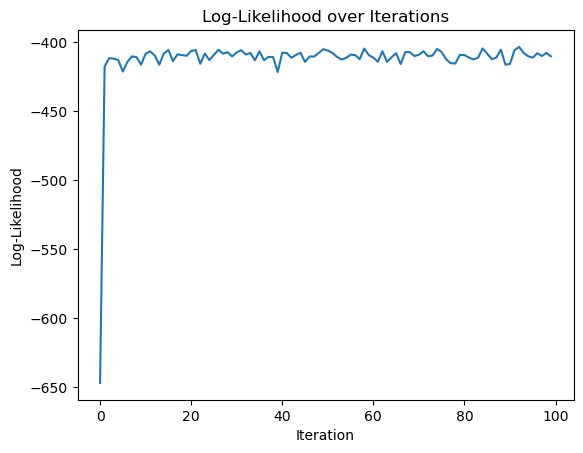

In [15]:
# Generate synthetic data
gibbs_sampler = GMMGibbsSampler(K=3, sigma2_0=1, tau2_0=1, mu_0=0, alpha_0=1)
z, mu, pi, log_likelihoods = gibbs_sampler.fit(X)

# Report estimated mu & pi
print("Estimated means:")
print(mu)
print("Estimated mixing coefficients:")
print(pi)

# Plot the log-likelihoods over iterations
plt.plot(log_likelihoods)
plt.title('Log-Likelihood over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.show()

In [21]:
# Apply GMM Gibbs Sampler on the digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# Normalise the data
X_normalised = X / 16.0  # Pixel values are in [0, 16]

# Initialise K & the hyperparameters
K = len(np.unique(y))
sigma2_0 = np.var(X_normalised)  # Data variance
tau2_0 = sigma2_0 
mu_0 = np.mean(X_normalised)  # Set prior mean to be the overall mean
alpha_0 = 0.1 

# Create Gibbs sampler instance & fit
gibbs_sampler = GMMGibbsSampler(K=K, sigma2_0=sigma2_0, tau2_0=tau2_0, mu_0=mu_0, alpha_0=alpha_0, n_iter=100)
z, mu, pi = gibbs_sampler.fit(X_normalised)

# The cluster assignments can be used to classify the digits
print("Cluster assignments for the digits:")
print(z)

Cluster assignments for the digits:
[5 0 0 ... 0 5 5]


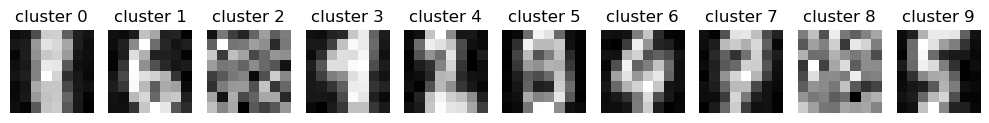

In [22]:
# Reshape the cluster centers into 8x8 images
cluster_centers_images = [center.reshape((8, 8)) for center in mu]

# Plot the cluster centers as images
fig, axes = plt.subplots(1, K, figsize=(10, 5))
for i, (ax, center_img) in enumerate(zip(axes, cluster_centers_images)):
    ax.imshow(center_img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'cluster {i}')

plt.tight_layout()
plt.show()